<a href="https://colab.research.google.com/github/lleviraz/urban_segmentation/blob/main/notebooks/Experiments_Results_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysys of the Segmentation Results 

This notebook contains the Segmentation pipeline results analysis using fastai
It assumes that the dataset was already preprocessed and available in two directories:
- s2_resized - the input images
- esm_aligned - the ESM masks

A model was trained and saved: `models/best_model.pt`

Results file: `results_log.csv`

Test data and predidictions:
- s2_resized_test - images for test not used in training
- esm_resized_test - masks of the above test images (unused)
- preds - predicted masks based on test data

By: Eli T. and Liad.L.

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install fastai wwf nbdev rasterio geopandas fastbook tiffile imagecodecs pytorch-ignite -q
# !pip install wwf nbdev rasterio pytorch-ignite -q --upgrade

from wwf.utils import state_versions
state_versions(['wwf','rasterio','pytorch-ignite'])


---
This article is also a Jupyter Notebook available to be run from the top down. There
will be code snippets that you can then run in any environment.

Below are the versions of `wwf`, `rasterio`, and `pytorch-ignite` currently running at the time of writing this:
* `wwf` : 0.0.16 
* `rasterio` : 1.2.10 
* `pytorch-ignite` : 0.4.8 
---

In [ ]:
# Python General
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import shutil

from pathlib import Path
import glob
from tqdm.notebook import tqdm
import pprint as pp
from PIL import Image
import numpy as np

#Torch
from torch import nn
import torch
import torch.nn.functional as F
from torchvision.transforms import *
from torchvision.transforms.functional import InterpolationMode
from torchvision.models.resnet import resnet18,resnet34,resnet50,resnet101
# from ignite.metrics import SSIM


#rasterio
import rasterio as rio
from rasterio.transform import Affine
from rasterio.plot import show_hist,show
from rasterio.warp import calculate_default_transform, reproject, Resampling

#fastai
from fastcore.xtras import Path
from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_flat_cos
from fastai.data import *
from fastai.data.block import DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize
from fastai.layers import Mish
from fastai.losses import BaseLoss,DiceLoss,FocalLossFlat
from fastai.optimizer import ranger,Adam
from fastai.torch_core import tensor
from fastai.vision.all import *
from fastai.vision.augment import aug_transforms
from fastai.vision.learner import unet_learner
from fastai.vision import *
from fastai.vision.core import *
from fastai.vision.data import *
from fastai.basics import *

In [ ]:
EXPORT_DIR='/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset'
os.chdir('/content/drive/MyDrive/2022/S1/3624_Final_Project/notebooks')
sys.path.append('/content/drive/MyDrive/2022/S1/3624_Final_Project/notebooks')

ESM_DIR = EXPORT_DIR + '/ESM'
S2_DIR = EXPORT_DIR + '/S2'

OVERFIT=False

if OVERFIT==False:
  esm_aligned = os.path.join(EXPORT_DIR ,'esm_aligned/')
  s2_resized = os.path.join(EXPORT_DIR,'s2_resized')
  S2_TEST_DIR = s2_resized + '_test'
  ESM_TEST_DIR = esm_aligned + '_test'
else:
  #Testing the model can learn to overfit
  esm_aligned = os.path.join(EXPORT_DIR ,'esm_4overfit/')
  s2_resized = os.path.join(EXPORT_DIR,'s2_4overfit/')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu' #GOOD FOR DEBUGGING
print('Using device:', device)

Using device: cpu


In [ ]:
from libs.preprocess import *
from libs.metrics import *
from libs.multichannel import *
from libs.metrics import _fast_hist

In [ ]:
trn = glob.glob(os.path.join(s2_resized,'*.tif'))
trn_number_files = len(trn)
print('{} train files in {}'.format(trn_number_files,s2_resized))
tst = glob.glob(os.path.join(S2_TEST_DIR,'*.tif'))
tst_number_files = len(tst)
print('{} test files in {}'.format(tst_number_files,S2_TEST_DIR))

650 train files in /content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized
50 test files in /content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized_test


### Classes codes decoder dictionary (0,1,2,3)->(0,1,250,255)

In [ ]:
codes = ['0_No_Data','1_Land','250_Non_Resi_BU','255_Resi_BU']
codes

['0_No_Data', '1_Land', '250_Non_Resi_BU', '255_Resi_BU']

In [ ]:
# From np.unique(mask)
mask_vals = {0:0,1:1,2:250,3:255}

In [ ]:
fnames = get_image_files(s2_resized)
lbl_names = get_image_files(esm_aligned)
fnames,lbl_names

((#650) [Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_0.tif'),Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_1.tif'),Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_2.tif'),Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_3.tif'),Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_4.tif'),Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_5.tif'),Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_9.tif'),Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_6.tif'),Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_11.tif'),Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/s2_resized/R_1_10.tif')...],
 (#650) [Path('/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/esm_aligned/ESM_0.tif'),Path('/content/dr

In [ ]:
#TODO try to remove class 1 into class 0 as "background class"
def get_msk(img_name,mask_dir, p2c,merge_bg=False):
  '''
  returns a matching mask for an image using the codes decoder dictionary (0,1,2,3)->(0,1,250,255)
  '''
  fn = get_matching_mask_path(img_name,mask_dir)
  msk = np.array(PILMask.create(fn))
  for i, val in enumerate(p2c):
    msk[msk==p2c[i]] = val
 
  if(merge_bg):
    msk[msk==0] = 1
    msk[0,0]=0 #save one pixel as 0 to preseve the "colors" when comparing
  return PILMask.create(msk)

In [ ]:
img_fn = fnames[3].name
msk = get_msk(img_fn,esm_aligned,mask_vals)

In [ ]:
# !ls /content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/esm_aligned/ESM_0.tif

In [ ]:
cm='Accent' #'nipy_spectral_r'


((array([0, 1, 2, 3], dtype=uint8), array([ 7443, 66850,    68, 15639])),
 (array([0, 1, 2, 3], dtype=uint8), array([ 7443, 66850,    68, 15639])))

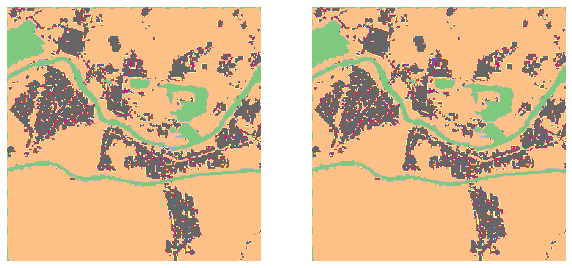

In [ ]:
f,axs = plt.subplots(1,2,figsize=(10,10))
msk.show(figsize=(5,5), alpha=1.,cmap=cm,ax=axs[0])
msk2 = get_msk(img_fn,esm_aligned,mask_vals)#,merge_bg=True)
msk2.show(figsize=(5,5), alpha=1.,cmap=cm,ax=axs[1])
np.unique(tensor(msk),return_counts=True),np.unique(tensor(msk2),return_counts=True)

In [ ]:
msk.shape,msk2.shape

((300, 300), (300, 300))

In [ ]:
def get_counts(a,b):
  print('\n counts:',a.shape,b.shape)
  print(np.unique(tensor(a),return_counts=True),'\n',np.unique(tensor(b),return_counts=True))

def prep_hist_no_bg(inp,targ):
  '''
  prepare tensors for evaluation
  '''
  get_counts(inp,targ)

  targ[targ == 0]=1
  targ[0,0]=0
  inp[inp == 0]=1
  inp[0,0]=0
  targ2=targ.type(torch.IntTensor)
  inp2=inp.type(torch.IntTensor)
  
  get_counts(inp2,targ2)
  
  targ = targ2.squeeze(1).cpu()
  pred=inp2.squeeze(1).cpu()#.argmax(dim=1).cpu()
  n_clss=len(np.unique(inp2))
  
  print('\nn_cls=',n_clss,targ.shape,pred.shape)
  hist = torch.zeros((n_clss, n_clss)).cpu()
  for t, p in zip(targ, pred):
      hist += _fast_hist(t.flatten(), p.flatten(), n_clss)
  print(hist)
  return hist

In [ ]:
def dice_coefficient_no_bg(hist):
    A_inter_B = torch.diag(hist)
    A = hist.sum(dim=1)
    B = hist.sum(dim=0)
    dice = (2 * A_inter_B) / (A + B + EPS)
    avg_dice = nanmean(dice)
    return avg_dice

In [ ]:
msk=transforms.ToTensor()(msk)
msk2=transforms.ToTensor()(msk2)
msk = msk.cpu()
msk2 = msk2.cpu()
n_clss=len(np.unique(msk))
print('acc={:.4f} \nper_cls_acc={:.4f} \nIoU={:.4f} \nDice={:.4f}'.format(*eval_metrics(msk,msk2,4)))

acc=1.0000 
per_cls_acc=1.0000 
IoU=1.0000 
Dice=1.0000


In [ ]:
# h=prep_hist(msk,msk2)
# d=dice_coefficient_no_bg(h)
# print('dice no bg={:.4f}'.format(d))

## Store results of experiments and save to a log


In [ ]:
cols=['datetime','model','num_epochs','loss_fn','batch_size',
      'arch','optim','channels','pretrained','lr','valid_pct',
      'trn_loss','val_loss','acc','per_cls_acc','IoU','Dice','DiceMulti', 'foreground_acc','item_augs','batch_augs','epoch_time']
deeplab_results=pd.read_csv('deeplab_results_log.csv',names=cols)
results=pd.read_csv('results_log.csv',names=cols)
# results2 = pd.read_csv('results_log_11Feb_15Feb.csv',names=cols)
# new_expriment_log=[dt_string,model,log[0],(loss_fn.__class__.__name__,loss_fn.display()),batch_size,
# new_expriment_log=[dt_string,model,log[0],(loss_fn.display()),batch_size,
#       arch.__name__,opt.__name__,channels,pretrained,min_grad_lr,valid_pct,
#       log[1],log[2],log[3],log[4],log[5],log[6],augs_list,batch_augms,log[-1]]

# results.loc[len(results)] = new_expriment_log
results.head(2)

,datetime,model,num_epochs,loss_fn,batch_size,arch,optim,channels,pretrained,lr,valid_pct,trn_loss,val_loss,acc,per_cls_acc,IoU,Dice,DiceMulti,foreground_acc,item_augs,batch_augs,epoch_time
0,15/02/2022 15:33:50,unet_fastai,119,"DiceFocalLoss(1,1e-06,0.1,2.0,mean,False)",5,resnet34,ranger,NaN,False,0.000091,0.15,0.215617,0.227086,0.795096,0.701288,0.547672,0.686060,NaN,NaN,"['RandomSizedCrop', 'PadIfNeeded', 'VerticalFlip', 'RandomRotate90', 'RandomBrightnessContrast']",NaN,00:38
1,15/02/2022 15:33:50,unet_fastai,32,"DiceFocalLoss(1,1e-06,0.1,2.0,mean,False)",5,resnet34,ranger,NaN,False,0.000091,0.15,0.221100,0.230138,0.793960,0.666408,0.533033,0.669724,NaN,NaN,"['RandomSizedCrop', 'PadIfNeeded', 'VerticalFlip', 'RandomRotate90', 'RandomBrightnessContrast']",NaN,00:44


In [ ]:
deeplab_results.head(2)

,datetime,model,num_epochs,loss_fn,batch_size,arch,optim,channels,pretrained,lr,valid_pct,trn_loss,val_loss,acc,per_cls_acc,IoU,Dice,DiceMulti,foreground_acc,item_augs,batch_augs,epoch_time
0,02/03/2022 17:36:34,deeplabv3_fastai,20,"DiceFocalLoss(1,1e-06,0.07,5.5,mean,False)",2,resnet34,ranger,"[12, 13, 14]",False,0.007586,0.1,0.553282,0.510198,0.773612,0.523861,0.398685,0.510212,0.642077,0.560655,"['RandomSizedCrop', 'PadIfNeeded', 'VerticalFlip', 'RandomRotate90', 'RandomBrightnessContrast']",NaN,00:40
1,02/03/2022 18:01:44,deeplabv3_fastai,62,"DiceFocalLoss(1,1e-06,0.07,5.5,mean,False)",5,resnet34,ranger,"[7, 12, 14]",True,0.002089,0.1,0.091764,0.099685,0.751675,0.598002,0.473946,0.618305,0.677563,0.708587,"['RandomSizedCrop', 'PadIfNeeded', 'VerticalFlip', 'RandomRotate90', 'RandomBrightnessContrast']",NaN,00:33


In [ ]:

report_cols = ['num_epochs', 'lr', 'valid_pct', 'trn_loss',
       'val_loss', 'acc', 'per_cls_acc', 'IoU', 'Dice', 'DiceMulti',
       'foreground_acc', 'epoch_time']
nn_results = results[report_cols].fillna(0.0)
# nn_results.describe()

In [ ]:
# f,(ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
# corr = nn_results.corr()
# scorr = nn_results.corr(method = 'spearman')
# cm = 'cividis'
# sns.heatmap(corr, annot = True,vmin=-1,vmax=1,ax=ax1,cmap=cm)
# ax1.set_title('Pearson')
# sns.heatmap(scorr, annot = True,vmin=-1,vmax=1,ax=ax2,cmap=cm)
# ax2.set_title('Spearman')

# plt.show()

In [ ]:
import re
df = pd.DataFrame(columns=['loss_func','val_loss','alpha','gamma','Dice','foreground_acc'])
loss_fncs=results['loss_fn'].str.split(',')
for i,result in enumerate(loss_fncs):
  
  if(result[0].startswith('DiceFocalLoss')):
    alpha,gamma=float(result[2]),float(result[3])
  else:
    alpha,gamma=np.nan,np.nan
  
  loss_func = re.sub('[^A-Za-z]+', '', result[0])
  df.loc[len(df)] = loss_func, \
                    float(results.iloc[i]['val_loss']), \
                    alpha,gamma, \
                    float(results.iloc[i]['Dice']), \
                    float(results.iloc[i]['foreground_acc'])
  # print(result[i][3],result[i][4])
np.unique(df['loss_func'])

array(['CrossEntropyLossFlat', 'DiceFocalLoss', 'DiceLoss',
       'FocalLossFlat'], dtype=object)

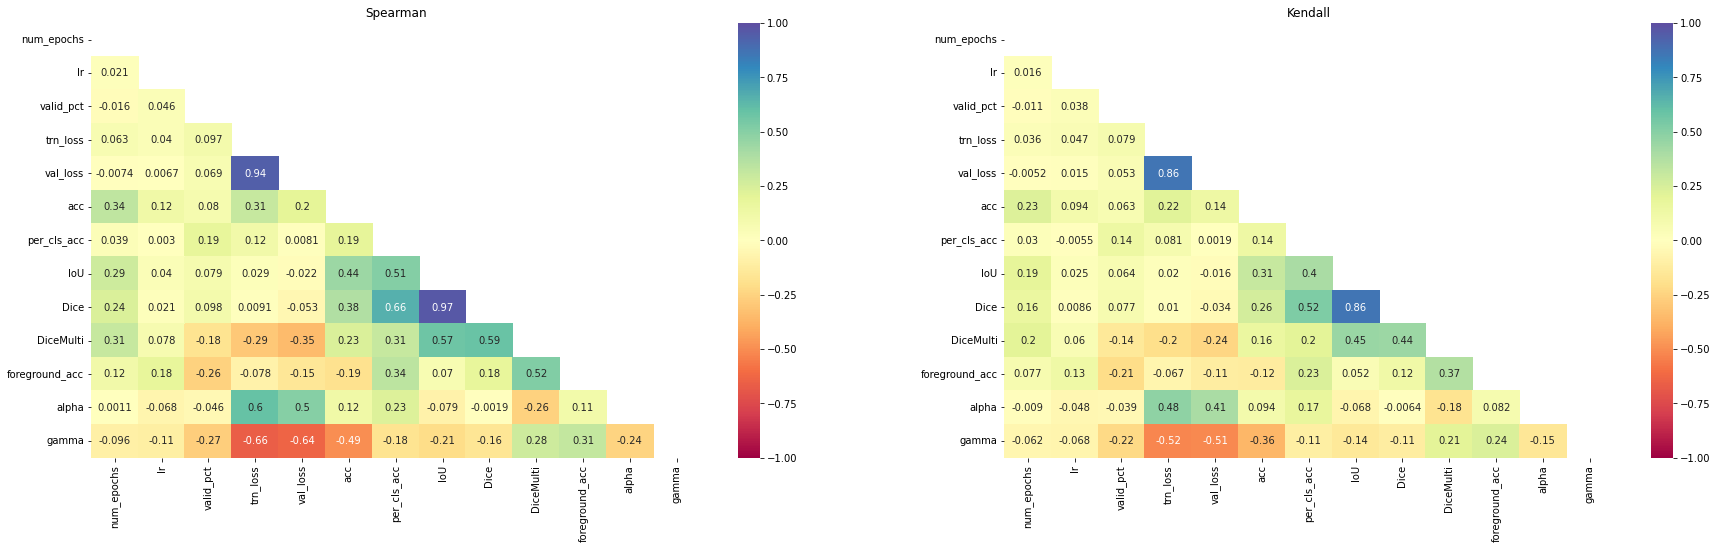

In [ ]:
for column in ['alpha','gamma']:
  nn_results[column] = df[column].fillna((df[column].mean()))

f,(ax1,ax2) = plt.subplots(1,2,figsize=(30,8))
# corr = nn_results.corr()
scorr = nn_results.corr(method = 'spearman')
kcorr = nn_results.corr(method = 'kendall')

# Generate a mask for the upper triangle
smask = np.triu(np.ones_like(scorr, dtype=bool))
kmask = np.triu(np.ones_like(kcorr, dtype=bool))

cm = 'Spectral'
# sns.heatmap(corr, annot = True,vmin=-1,vmax=1,ax=ax1,cmap=cm)
# ax1.set_title('Pearson')
sns.heatmap(scorr, annot = True,vmin=-1,vmax=1,ax=ax1,cmap=cm,mask=smask)
ax1.set_title('Spearman')
sns.heatmap(kcorr, annot = True,vmin=-1,vmax=1,ax=ax2,cmap=cm,mask=kmask)
ax2.set_title('Kendall')

plt.show()


In [ ]:
# nn_results
# sns.lmplot(y='val_loss',x='foreground_acc',data=df,fit_reg=True) 

In [ ]:
# df.plot.scatter(x='alpha',y='Dice')
# sns.lmplot(x='alpha',y='Dice',data=df,fit_reg=True) 

In [ ]:
# df.plot.scatter(x='gamma',y='Dice')
# sns.lmplot(x='gamma',y='Dice',data=df,fit_reg=True) 

In [ ]:
# df.plot.scatter(x='gamma',y='val_loss')
# sns.lmplot(x='alpha',y='val_loss',data=df,fit_reg=True) 

In [ ]:
nn_results['epoch_time'] = nn_results['epoch_time'].str.replace(':', '').astype(float)
# nn_results['epoch_time'].head()

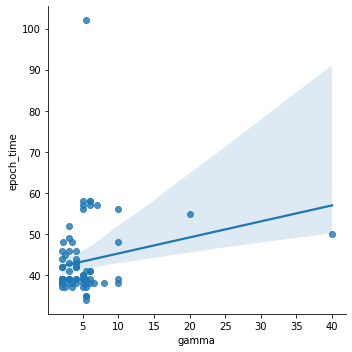

In [ ]:
sns.lmplot(x='gamma',y='epoch_time',data=nn_results) 

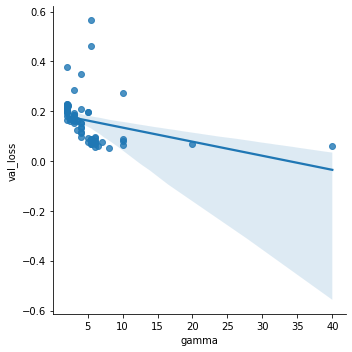

In [ ]:
# df.plot.scatter(x='gamma',y='val_loss')
sns.lmplot(x='gamma',y='val_loss',data=df) 

In [ ]:
# sns.lmplot(x='Dice',y='val_loss',data=df,fit_reg=True) 

In [ ]:
# results.to_csv('results_log.csv', mode='a', index=False, header=False)
# scores_cols=['acc','per_cls_acc','IoU',	'Dice']
scores_cols=['per_cls_acc','IoU',	'Dice']
# results[scores_cols].plot.bar()

In [ ]:
print('best mean score: {}'.format(results[scores_cols].mean(axis=1).max()))
# results.iloc[results[scores_cols].mean(axis=1).argmax()]

best mean score: 0.6798954804738363


# Compare various hyper params and architechtures results

## Compare pretrained resnet archs vs Val loss , Dice

TODO


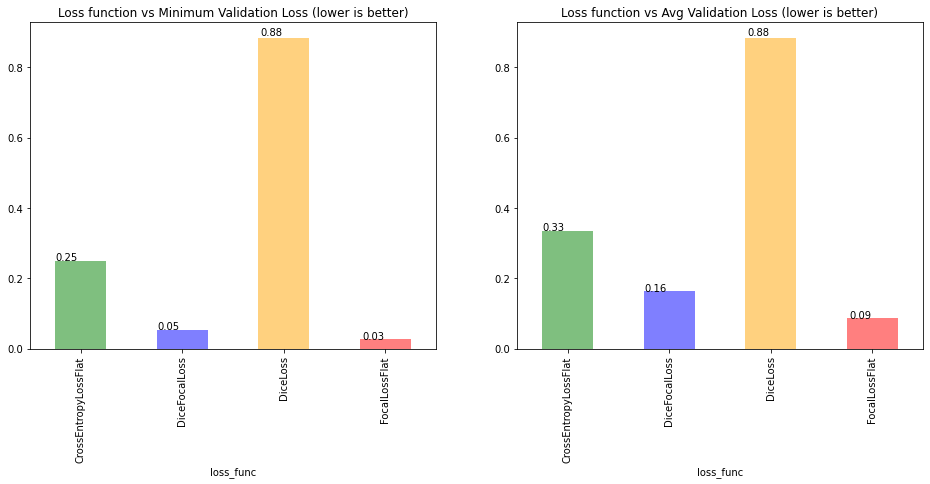

In [ ]:
colors=['Green','Blue','Orange','Red','Purple']
f,(ax1,ax2)=plt.subplots(1,2,figsize=(16,6))
df.groupby('loss_func')['val_loss'].min().plot.bar(title='Loss function vs Minimum Validation Loss (lower is better)',
                                                    color=colors,alpha=0.5,ax=ax1)
annotate(ax1)

df.groupby('loss_func')['val_loss'].mean().plot.bar(title='Loss function vs Avg Validation Loss (lower is better)',
                                                    color=colors,alpha=0.5,ax=ax2)
annotate(ax2)

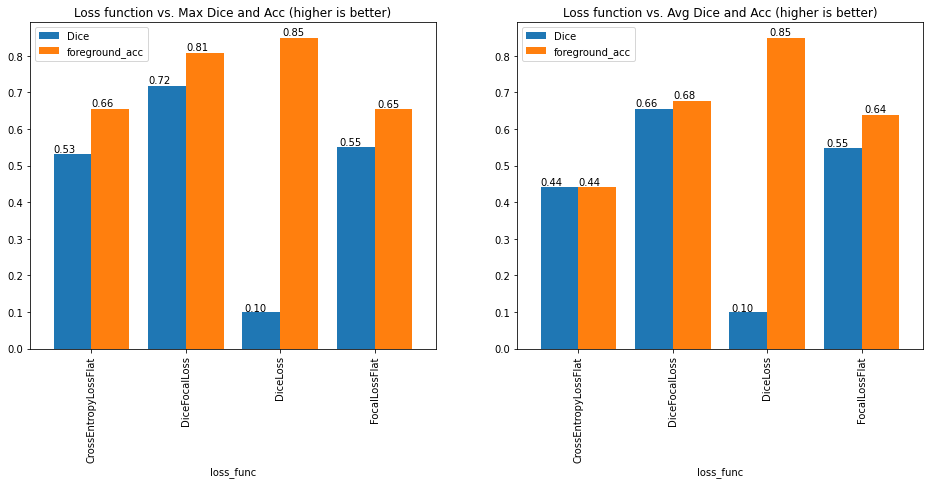

In [ ]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(16,6))
df.groupby('loss_func')['Dice',	'foreground_acc'].max().plot.bar(title='Loss function vs. Max Dice and Acc (higher is better)',ax=ax1,width=0.8)
annotate(ax1)

df.groupby('loss_func')['Dice',	'foreground_acc'].mean().plot.bar(title='Loss function vs. Avg Dice and Acc (higher is better)',ax=ax2,width=0.8)
annotate(ax2)


In [ ]:
df.iloc[df['Dice'].argmax()]

loss_func         DiceFocalLoss
val_loss               0.211189
alpha                       0.1
gamma                       2.0
Dice                   0.717016
foreground_acc         0.704053
Name: 18, dtype: object

### Compare class proprtions , similiarity of original and generated masks

First "predict" a mask for all the **training** data

In [ ]:
! ls ../models/model.pth


../models/model.pth


In [ ]:
# from fastbook import load_learner

# learn_inference = load_learner('../models/model.pth')

In [ ]:
# #load model
# learn_inference.load('models/last_model');

In [ ]:
# fnames = get_image_files(s2_resized)

# dl = learn.dls.test_dl(fnames)
# preds = learn.get_preds(dl=dl)
# preds[0].shape


In [ ]:
# #TODO move to preprocess.py
# def add_cls_counts(df,mask,classes_dic={'0':0,'1':0,'2':0,'3':0}):
#     '''
#     counting classes in masks to plot histograms and calculate dataset imbalance
#     '''
#     if isinstance(mask,TensorBase):
#         classes,counts = np.unique(mask,return_counts=True)
#     else:
#         classes,counts = np.unique(mask.read(1),return_counts=True)
#     new_row = list(counts)

#     if len(classes)<4:
#       new_row = classes_dic
#       for i,c in enumerate(classes):
#         new_row[str(c)]=counts[i]
      
#     df.loc[len(df)] = new_row

In [ ]:
#TODO move to preprocess.py
# cols = ['0','1','2','3']

# def get_bu_area_ratio(df,with_no_data=False):
#   c_255=df[cols[3]]
#   c_250=df[cols[2]]
#   c_one=df[cols[1]]
#   c_zero=df[cols[0]]
#   if(with_no_data):
#     total=c_zero+c_one+c_250+c_255
#   else:
#     total=c_one+c_250+c_255
#   return (c_250+c_255)/total

In [ ]:
# df_new_mask_class_counts = pd.DataFrame(columns=cols)
# for pred_mask in preds[0]:
#   # add_cls_counts(df_orig_mask_class_counts,orig_mask)
#   pred_arx = pred_mask.argmax(dim=0)
#   add_cls_counts(df_new_mask_class_counts,pred_arx,{'0':0,'1':0,'2':0,'3':0})


In [ ]:
# om=pd.read_csv('orig_masks_bu_area.csv',index_col=0,header=None)
# om=pd.read_csv('orig_masks_bu_area_w_nodata.csv',index_col=0,header=None)


In [ ]:
# nm=get_bu_area_ratio(df_new_mask_class_counts,with_no_data=True)
# nm=get_bu_area_ratio(df_new_mask_class_counts)

# f,ax1 = plt.subplots(1,1,figsize=(12,4))
# plot_hist(om,None,ax1,'Red',lbl='Orig')
# plot_hist(nm,'Orig and Pred Masks Ratio of Built-UP Areas',ax1,'Blue',lbl='Pred')
# plt.show()

In [ ]:
# f,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

# df_orig_mask_class_counts = pd.read_csv('df_orig_mask_class_counts.csv',index_col=0,header=None)

# plot_bar(df_orig_mask_class_counts,'Orig Mask Class Proportions',ax1)
# annotate(ax1)

# plot_bar(df_new_mask_class_counts,'Pred Mask Class Proportions',ax2)
# annotate(ax2)
# plt.show()

### Inference on unseen images

+ Saving predictions to a folder

In [ ]:
# test_fnames = get_image_files(S2_TEST_DIR)

# dl = learn.dls.test_dl(test_fnames)
# preds = learn.get_preds(dl=dl)
# preds[0].shape

In [ ]:
# PREDS_DIR= 'preds'

In [ ]:
# !rm -f preds/*.tif

In [ ]:
# %%time

# show_every=5
# nrows=int(len(test_fnames)/show_every)+1
# f,axes = plt.subplots(nrows,5,figsize=(24,nrows*6))
# j=0
# with rio.Env():
#   with rio.open(get_matching_mask_path(test_fnames[0].name,ESM_TEST_DIR),'r') as src:
#     profile = src.profile

#     for i in tqdm(range(len(test_fnames))):
#       pred_1 = preds[0][i]
#       pred_arx = pred_1.argmax(dim=0)

#       # stats = print_pred_stats(pred_arx,str(i)+' stats',mask_vals)

#       msk = get_msk(test_fnames[i].name,ESM_TEST_DIR,mask_vals)

#       if pred_arx.shape[0]!=1:
#         pred=pred_arx.unsqueeze_(0)
#       true=transforms.ToTensor()(msk)
#       if true.shape[0]!=1:
#         true.unsqueeze_(0)
#       true = true.cpu()
#       pred = pred.cpu()
#       pred_arx = pred_arx.cpu()


#       if i%show_every==0:
#         n_clss=len(np.unique(true))
#         overall_acc, avg_per_class_acc, avg_jacc, avg_dice = eval_metrics(true,pred,n_clss)
#         a_s = pred_1.argmax(dim=0).unsqueeze(0).to(torch.float)
#         b_s = transforms.ToTensor()(msk).unsqueeze_(0).to(torch.float)
        
#         m_ssim = SSIM(data_range=1.0); m_ssim.reset(); m_ssim.update((a_s.unsqueeze(0),b_s.unsqueeze(0))); m_ssim.compute()
#         ssim = m_ssim.compute()

#         stats = print_pred_stats(pred_arx,str(i)+' stats',mask_vals)

#         with rio.open(os.path.join(S2_TEST_DIR,test_fnames[i].name)) as matching_image:
#           show(normalize(matching_image.read([3,2,1])),ax=axes[j,0],title=test_fnames[i].name)
#         axes[j,1].imshow(msk,cmap=cm)
        
#         #To show the mask on top of the image
#         # axes[j,0].imshow(msk,cmap=cm,alpha=0.5)
        
#         msk_name = get_matching_mask_path(test_fnames[i].name, ESM_TEST_DIR).split(os.path.sep)[-1]
#         axes[j,1].set_title('Target mask ' + msk_name)
#         axes[j,2].imshow(pred_arx.squeeze(0),cmap=cm)
#         axes[j,2].set_title('Predicted mask')
#         axes[j,4].axis('off')
#         if(len(stats))<4:
#           stats.append('N/A')
#         axes[j,4].text(0.05, 0.25, '0:Green,1:Orange,250:Pink,255:Gray\nOverall_acc={:.4f}\navg_per_class_accuracy={:.4f} \
#                                   \navg_IoU={:.4f}\navg_dice={:.4f},\nssim={:.4f}\n{}\n{}\n{}\n{}'.format(
#                                   overall_acc, avg_per_class_acc, avg_jacc, avg_dice,ssim,*stats))
#         x = np.arange(5)
#         width = 0.9
#         scores = ['acc','per_cls_acc','IoU','Dice','SSIM']
#         values = [overall_acc,avg_per_class_acc,avg_jacc,avg_dice,ssim]
#         axes[j,3].bar(x, values , width ,color=[ 'cyan','orange', 'green', 'red','navy'])
#         axes[j,3].set_xticks(x)
#         axes[j,3].set_yticks(np.arange(0.0,1.1,0.1))
#         axes[j,3].set_xticklabels(scores,rotation=0)
#         j+=1

#         #save images to target dir
#         with rio.open(os.path.join(PREDS_DIR,test_fnames[i].name), 'w', **profile) as dst1:
#             dst1.write(true[0].numpy().astype(rio.uint8), 1)
#         with rio.open(os.path.join(PREDS_DIR,'pred_'+test_fnames[i].name), 'w', **profile) as dst2:
#             dst2.write(pred_arx[0].numpy().astype(rio.uint8), 1)
# plt.show()  

# Checking for "image duplicates" to find the similiarity of mask and predictions




In [ ]:
!pip install imagededup numpy -q --upgrade

     |████████████████████████████████| 42 kB 529 kB/s 
     |████████████████████████████████| 2.1 MB 6.7 MB/s 
     |████████████████████████████████| 4.4 MB 33.3 MB/s 
     |████████████████████████████████| 17.3 MB 45.1 MB/s 
     |████████████████████████████████| 462 kB 47.3 MB/s 
     |████████████████████████████████| 495.0 MB 28 kB/s 
     |████████████████████████████████| 1.3 MB 47.9 MB/s 
     |████████████████████████████████| 463 kB 34.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 0.18.2 requires numpy>=1.17, but you have numpy 1.16.6 which is incompatible.
tables 3.7.0 requires numpy>=1.19.0, but you have numpy 1.16.6 which is incompatible.
scikit-image 0.18.3 requires PyWavelets>=1.1.1, but you have pywavelets 1.0.3 which is incompatible.
pyerfa 2.0.0.1 requires numpy>=1.17, but you have numpy 1.16.6 which is incompatible.
panda

In [ ]:
!ls

 DEBUG
 DEBUG_S2
'DeepLab_Final_Proj_Segmentation Pipeline.ipynb'
 Deeplab_Segmentation.ipynb
 df_orig_mask_class_counts.csv
 Experiments_Results_Analysis.ipynb
 images
 libs
 orig_masks_bu_area.csv
 orig_masks_bu_area_w_nodata.csv
 preds
 results_log_11Feb_15Feb.csv
 results_log.csv
 results_log_untilFeb11th.csv
'S2 and ESM - EDA and Preprocessing.ipynb'
 stats_mean_df.csv
 stats_std_df.csv
'UNET_Final_Proj_Segmentation Pipeline.ipynb'


In [ ]:
!ls preds | wc -l

34


In [ ]:
from imagededup.methods import PHash, CNN

PREDS_DIR= 'preds'

cnn_encoder = CNN()
# duplicates_cnn = cnn_encoder.encode_images(image_dir=PREDS_DIR)


17235968/17225924 [==============================] - 0s 0us/step


2022-03-02 09:32:32,734: INFO Initialized: MobileNet pretrained on ImageNet dataset sliced at last conv layer and added GlobalAveragePooling


In [ ]:
dups_e = cnn_encoder.find_duplicates(image_dir=PREDS_DIR, scores=True,min_similarity_threshold=0.95)
# dups_e

2022-03-02 09:33:42,544: INFO Start: Image encoding generation


1/1 [==============================] - 3s 3s/step


2022-03-02 09:33:48,356: INFO End: Image encoding generation
2022-03-02 09:33:48,359: INFO Start: Calculating cosine similarities...
2022-03-02 09:33:48,361: INFO End: Calculating cosine similarities.


Duplicate detection by CNN:10 of 34


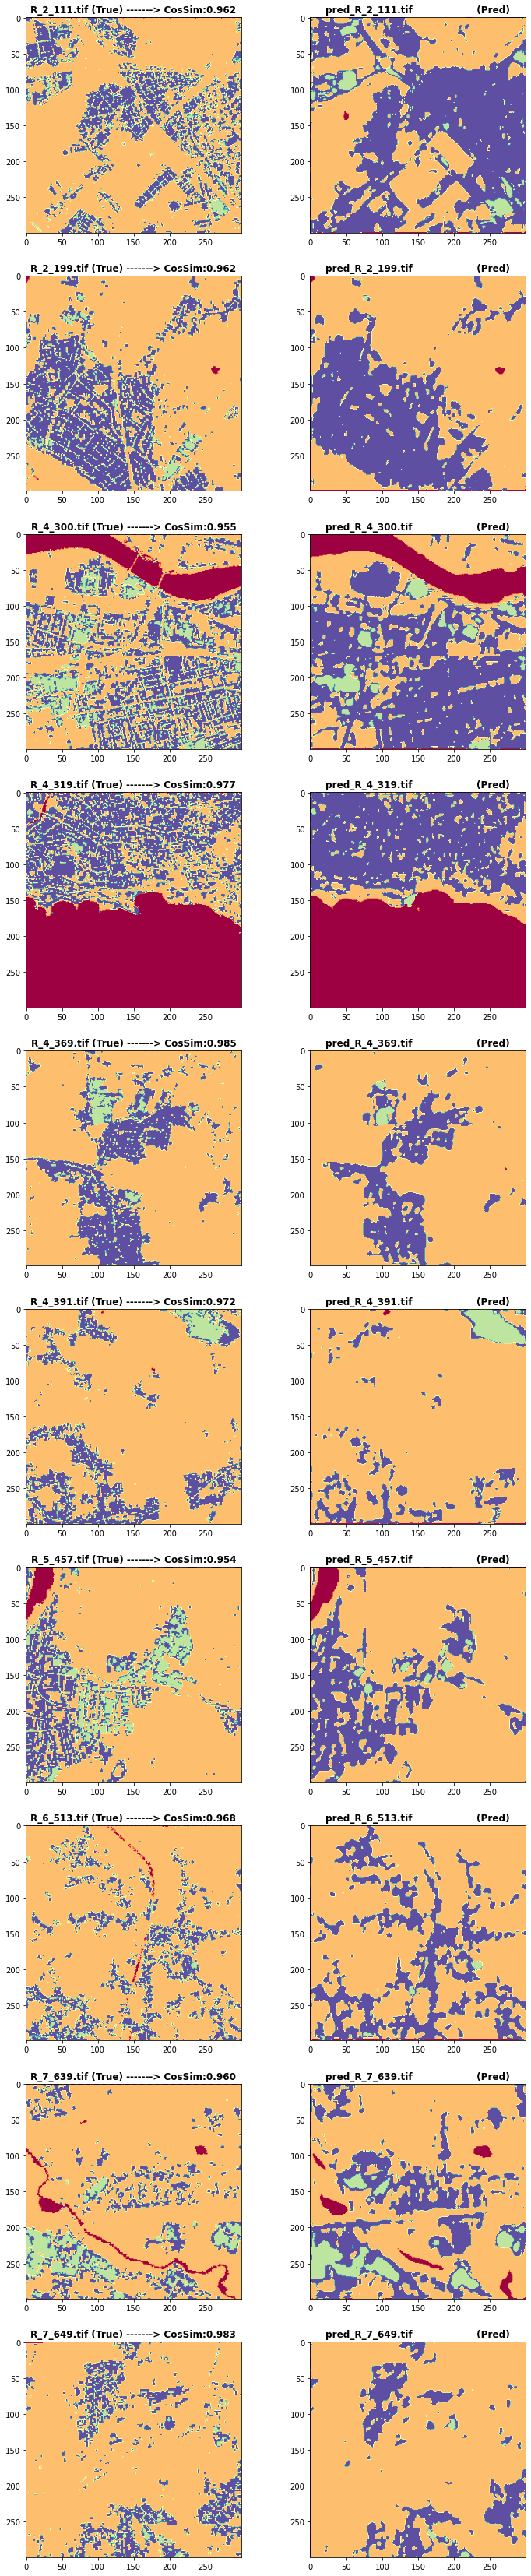

In [ ]:
cnt=0
dups = {}
for it in dups_e.items():
  if(it[0].startswith('pred_')):
    for dup in it[1]:
      if(it[0].endswith(dup[0])):
        dups[it[0]]=[dup]
        cnt+=1


f,axes = plt.subplots(cnt,2,figsize=(12,cnt*6))

j=0
for it in dups.items():
  if(it[0].startswith('pred_')):
    for dup in it[1]:
      if(it[0].endswith(dup[0])):
        display_image(Path(os.path.join(PREDS_DIR,it[0])),bands=[1],title=it[0] + '                    ' + '(Pred)',ax=axes[j,1],cm=cm,verbose=False)

        display_image(Path(os.path.join(PREDS_DIR,dup[0])),bands=[1],
                      title='{} (True) -------> CosSim:{:.3f}'.format(dup[0],dup[1]) ,ax=axes[j,0],cm=cm,verbose=False)
      j+=1

print('Duplicate detection by CNN:{} of {}'.format(cnt,len(dups_e)))

# TODOs



# Inference

In [ ]:
#Save and load models
# learn.save('stage-1')
# learn.load('stage-1');

References:

Some code snippets and inspiration:

https://gist.github.com/jaeeolma/0846e03c0c3b613212f8ca5824ae47e0

https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/07_Binary_Segmentation.ipynb

[Semantic Segmentation for Edge Detection](file:///C:/Users/liadl/Desktop/remotesensing-14-00613-v2.pdf)